In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
color_pal = sns.color_palette()
from sklearn.metrics import mean_squared_error

In [2]:
path = "C:\\Users\\CHARANA\\Desktop\\Predicta_01\\Data\\"

In [3]:
df_wthr = pd.read_csv(path + "historical_weather.csv")
df_wthr = df_wthr[["date", "city_id", "avg_temp_c"]]
df_wthr = df_wthr.set_index('date')
df_wthr.index = pd.to_datetime(df_wthr.index)
df_wthr.head()

,city_id,avg_temp_c
date,,
2014-01-01,C001,6.6
2014-01-02,C001,9.3
2014-01-03,C001,7.6
2014-01-04,C001,7.6
2014-01-05,C001,8.6


In [4]:
df_keys = pd.read_csv(path + "submission_key.csv")
df_keys.tail(50)

,submission_ID,city_id,date
650,651,C105,2019-01-07
651,652,C106,2019-01-01
652,653,C106,2019-01-02
653,654,C106,2019-01-03
654,655,C106,2019-01-04
655,656,C106,2019-01-05
656,657,C106,2019-01-06
657,658,C106,2019-01-07
658,659,C107,2019-01-01
659,660,C107,2019-01-02


In [5]:
df_wthr.isna().sum()/len(df_wthr)*100

city_id       0.000000
avg_temp_c    0.671281
dtype: float64

In [6]:
df_cities = {}

In [7]:
for i in df_wthr["city_id"].unique():
    df_cities[i] = df_wthr[df_wthr["city_id"] == i]

In [8]:
## Code speifically for C001

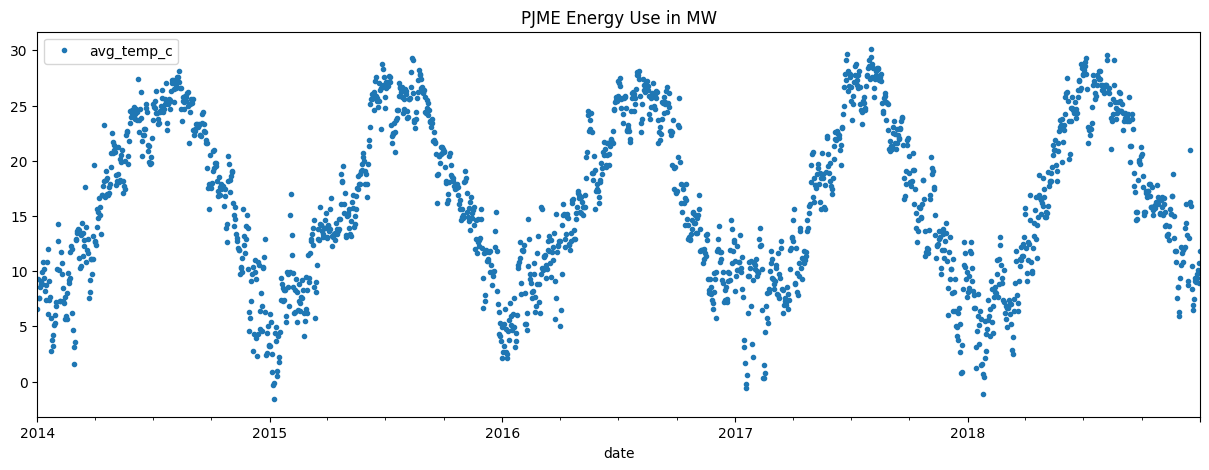

In [9]:
city =df_cities["C001"]
city.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

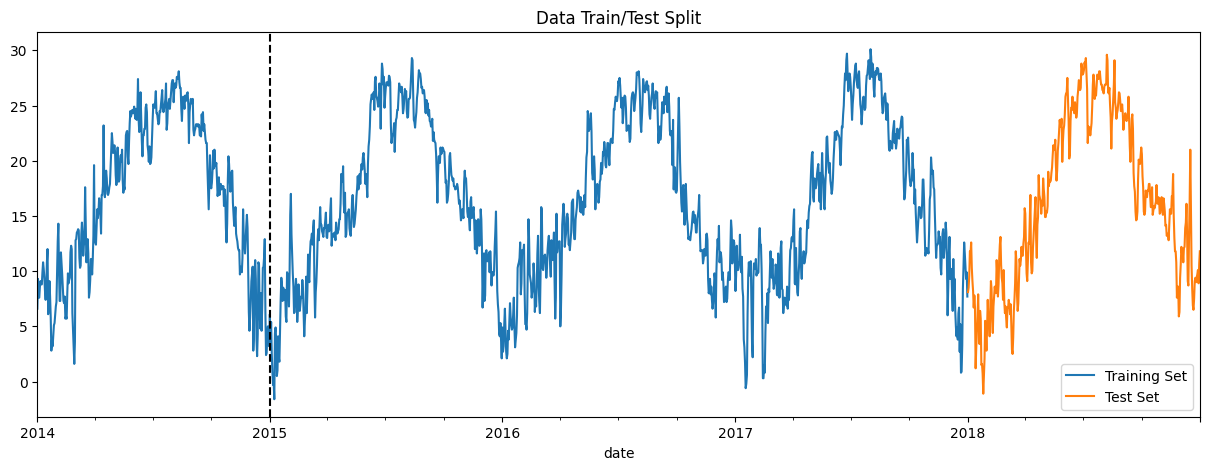

In [10]:
train = city.loc[city.index < '2018']
test = city.loc[city.index >= '2018']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

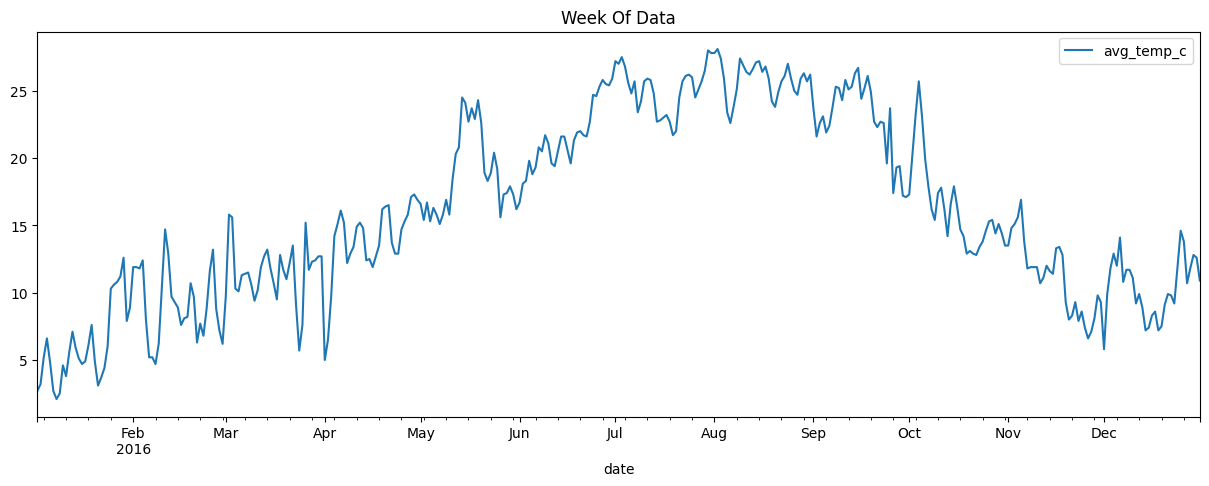

In [11]:
city.loc[(city.index > '2016') & (city.index < '2017')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

## Feature Creation

In [12]:
def create_features(df):
  df = df.copy()
  df = df.copy()
  df['dayofweek'] = df.index.dayofweek
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear
  df['dayofmonth'] = df.index.day
  df['weekofyear'] = df.index.isocalendar().week
  return df

In [13]:
city = create_features(city)
city.sample(10).head()

,city_id,avg_temp_c,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,,
2018-01-27,C001,2.1,5,1,1,2018,27,27,4
2018-12-21,C001,6.5,4,4,12,2018,355,21,51
2016-10-24,C001,13.8,0,4,10,2016,298,24,43
2017-05-19,C001,18.4,4,2,5,2017,139,19,20
2014-06-26,C001,21.3,3,2,6,2014,177,26,26


In [14]:
train = create_features(train)
test = create_features(test)

features = ["dayofweek","quarter","month","year","dayofyear","dayofmonth","weekofyear"]
target = "avg_temp_c"

x_train = train[features]
y_train = train[target]
x_test = test[features]
y_test = test[target]

In [15]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:17.16507	validation_1-rmse:17.33022
[100]	validation_0-rmse:6.77677	validation_1-rmse:7.12520
[200]	validation_0-rmse:3.35964	validation_1-rmse:3.85187
[300]	validation_0-rmse:2.48145	validation_1-rmse:3.05096


c:\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:49:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[400]	validation_0-rmse:2.28287	validation_1-rmse:2.90570
[500]	validation_0-rmse:2.19529	validation_1-rmse:2.87970
[511]	validation_0-rmse:2.18814	validation_1-rmse:2.88041


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

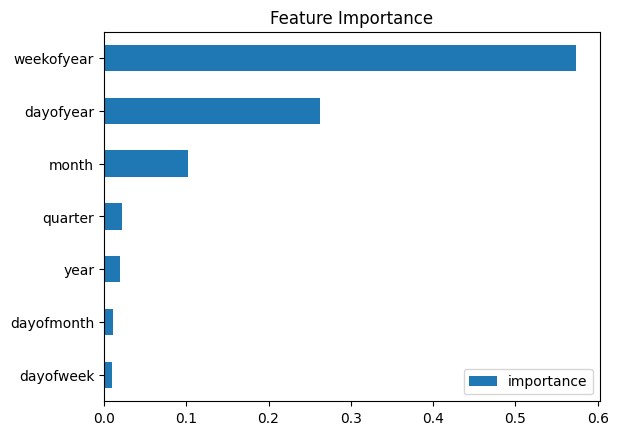

In [16]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

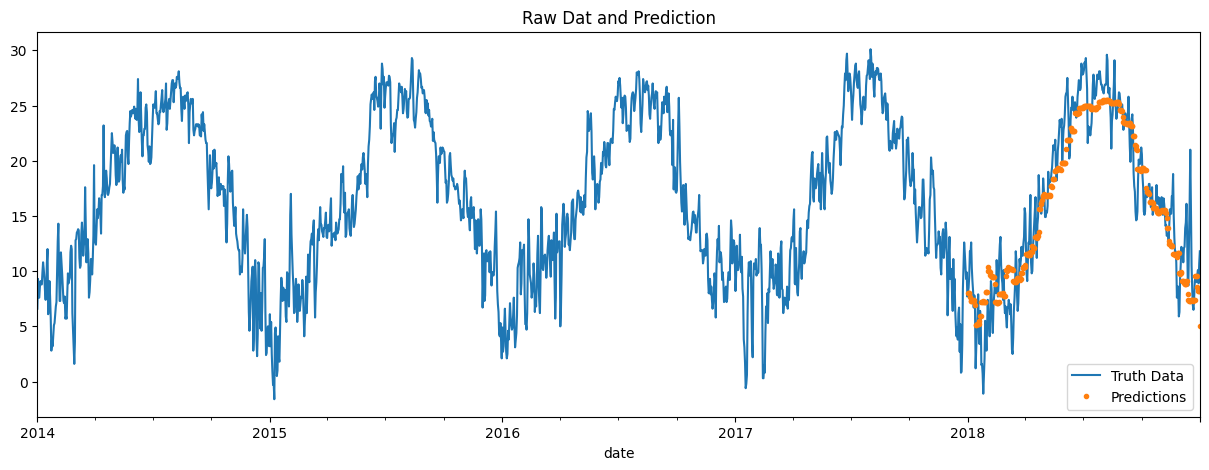

In [17]:
test['prediction'] = reg.predict(x_test)
city = city.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = city[['avg_temp_c']].plot(figsize=(15, 5))
city['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

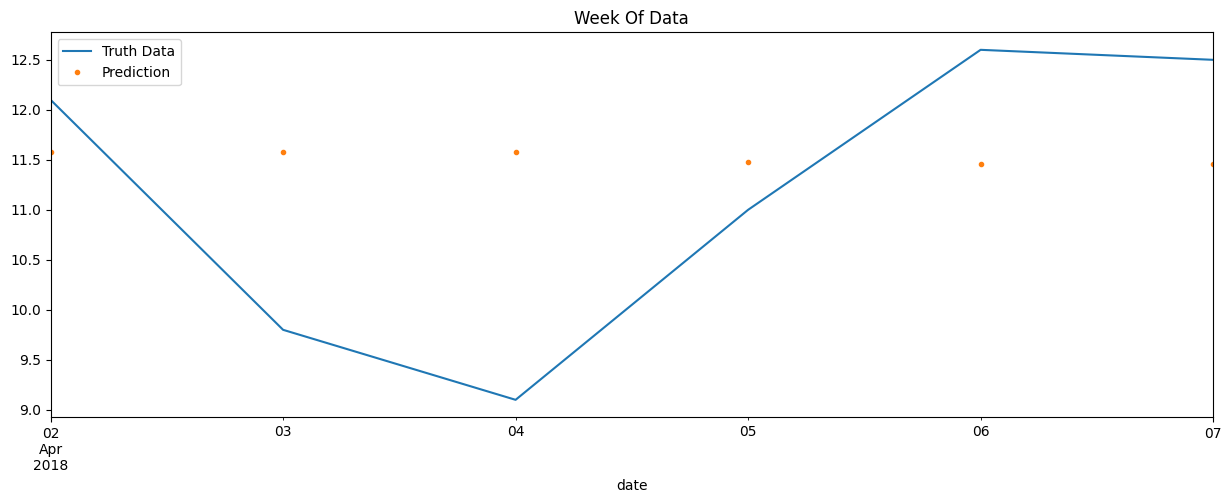

In [18]:
ax = city.loc[(city.index > '04-01-2018') & (city.index < '04-08-2018')]['avg_temp_c'] \
    .plot(figsize=(15, 5), title='Week Of Data')
city.loc[(city.index > '04-01-2018') & (city.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [19]:
score = np.sqrt(mean_squared_error(test['avg_temp_c'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 2.88
